 # Python Practice for ProMP (adaptation)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from utils import (load_letter_all, split_indices, preprocess_demo, denormalize,
                   rmse, endpoint_err, jerk_score, timer, append_csv)

#################################################<br>
Load the training data<br>
#################################################

In [18]:
mat = loadmat('../2Dletters/A.mat')
demosNum = 5 # number of demonstrations
dt = 0.005 # time interval
dataset = []
for i in range(demosNum):
    pos = mat['demos'][0, i]['pos'][0, 0]
    vel = np.gradient(pos, axis=-1) / dt
    pv = np.block([[pos], [vel]])
    dataset.append(pv)

#################################################<br>
Set parameters for ProMP<br>
#################################################

In [19]:
dim = 2  # 2D trajectory
Dim = 2 * dim # both position and velocity
len = dataset[0].shape[1] # length of demonstrations
tau = dt * len # motion duration
t0 = np.linspace(dt, tau, num=len)
center = np.linspace(0, 1, 20) # centers of basis functions
basisNum = center.shape[0]  # number of basis functions
width = 50 # width of basis functions
lb1 = 1
lb2 = 10

#################################################<br>
Define basis functions<br>
#################################################

In [20]:
def BasisFunction(t):
    Phi_1 = np.zeros(basisNum)
    addsum = 0
    for b in range(basisNum):
        Phi_1[b] = np.exp(-width * (t / tau - center[b]) ** 2)
        addsum = addsum + Phi_1[b]
    Phi_1 = Phi_1 / addsum
    Phi_2 = np.zeros(basisNum)
    addsum = 0
    for b in range(basisNum):
        Phi_2[b] = np.exp(-width * ((t + dt) / tau - center[b]) ** 2)
        addsum = addsum + Phi_2[b]
    Phi_2 = Phi_2 / addsum
    Phi_2 = (Phi_2 - Phi_1)/dt
    Phi_extend = np.zeros((Dim, basisNum*dim))
    for i in range(dim):
        Phi_extend[i, i*basisNum:(i+1)*basisNum] = Phi_1
    for i in range(dim):
        Phi_extend[dim+i, i * basisNum:(i+1)*basisNum] = Phi_2
    return Phi_extend

###############################################################<br>
Define the update function for trajectory parameters<br>
###############################################################

In [21]:
def update_w(t, desPoint, noisevar, mu_w, cov_w):
    Phi=BasisFunction(t)
    pred_pv = np.matmul(Phi,mu_w)
    sigma_Phi=np.matmul(cov_w, np.transpose(Phi))
    invL = np.linalg.pinv(np.matmul(Phi, sigma_Phi) + noisevar)
    sigma_Phi_invL = np.matmul(sigma_Phi, invL)
    mu_w_new = mu_w + np.matmul(sigma_Phi_invL, desPoint-pred_pv)
    cov_w_new = cov_w - np.matmul(sigma_Phi_invL, np.transpose(sigma_Phi))
    return mu_w_new, cov_w_new

###############################################################<br>
Estimate the distribution of the trajectory parameter vector w<br>
###############################################################

In [22]:
Phi = np.zeros((Dim*len, basisNum*dim))
weights = np.zeros((demosNum, basisNum*dim))
mu_w = np.zeros(basisNum*dim)
cov_w = np.zeros((basisNum*dim, basisNum*dim))

In [23]:
for i in range(len):
    Phi[i*Dim:(i+1)*Dim, :] = BasisFunction(t0[i])
PhiT_Phi = np.matmul(np.transpose(Phi), Phi) + lb1 * np.eye(basisNum*dim)
cw = np.matmul(np.linalg.pinv(PhiT_Phi), np.transpose(Phi))

In [24]:
# Estimate the trajectory parameter vector w from each demonstration
for i in range(demosNum):
    expandedTraj = dataset[i].flatten(order='F') # concatenate all columns into a column vector
    weights[i, :] = np.matmul(cw, expandedTraj)

In [25]:
# Calculate the mean and covariance of w
mu_w = np.mean(weights, axis=0)
cov_w = np.matmul(np.transpose(weights - mu_w), weights - mu_w) / demosNum + lb2 * np.eye(basisNum*dim)

#################################################<br>
Define desired points and modulate w<br>
#################################################

In [26]:
via_time1 = 3.0/8
via_point1 = np.array([3, 5, 0, 0]) # first desired point, format:[2D pos, 2D vel]
via_time2 = 1.0
via_point2 = np.array([8, 2, 0, 0]) # second desired point, format:[2D pos, 2D vel]

In [27]:
via_var = 0.01 * np.eye(Dim) # inversely proportional to the adaptation precision
# via_var[2, 2] = 1000 # a large error is allowed for vx
# via_var[3, 3] = 1000 # a large error is allowed for vy

In [28]:
# Update the distribution of w using each desired point
[mu_w_new, cov_w_new] = update_w(via_time1, via_point1, via_var, mu_w, cov_w)
[mu_w_new, cov_w_new] = update_w(via_time2, via_point2, via_var, mu_w_new, cov_w_new)

#################################################<br>
Prediction using ProMP<br>
#################################################

In [29]:
pred_pv = np.zeros((Dim, len))
for i in range(len):
    pred_pv[:, i] = np.matmul(BasisFunction(t0[i]), mu_w_new)

#################################################<br>
Plot predicted trajectories<br>
#################################################-

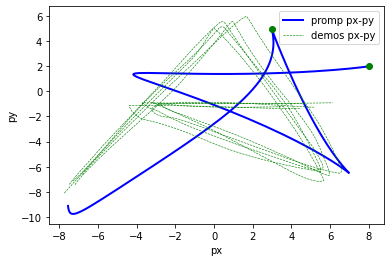

In [30]:
plt.plot(pred_pv[0], pred_pv[1], 'b', label='promp px-py', linewidth=2)
for i in range(demosNum):
   if i == 0:
       plt.plot(dataset[i][0], dataset[i][1], 'g--', linewidth=0.6, label='demos px-py')
   else:
       plt.plot(dataset[i][0], dataset[i][1], 'g--', linewidth=0.6)
plt.plot(via_point1[0], via_point1[1], 'go')
plt.plot(via_point2[0], via_point2[1], 'go')
plt.xlabel("px")
plt.ylabel("py")
plt.legend()
plt.show()

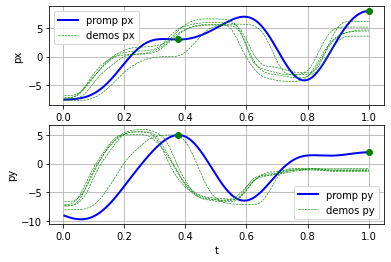

In [31]:
ax1 = plt.subplot(2, 1, 1)
ax1.plot(t0, pred_pv[0], 'b', label='promp px', linewidth=2)
for i in range(demosNum):
    if i == 0:
        ax1.plot(t0, dataset[i][0], 'g--', linewidth=0.6, label='demos px')
    else:
        ax1.plot(t0, dataset[i][0], 'g--', linewidth=0.6)
plt.plot(via_time1, via_point1[0], 'go')
plt.plot(via_time2, via_point2[0], 'go')
ax1.set_ylabel("px")
plt.legend()
ax1.grid()
ax2 = plt.subplot(2, 1, 2)
ax2.plot(t0, pred_pv[1], 'b', label='promp py', linewidth=2)
for i in range(demosNum):
    if i == 0:
        ax2.plot(t0, dataset[i][1], 'g--', linewidth=0.6, label='demos py')
    else:
        ax2.plot(t0, dataset[i][1], 'g--', linewidth=0.6)
plt.plot(via_time1, via_point1[1], 'go')
plt.plot(via_time2, via_point2[1], 'go')
ax2.set_ylabel("py")
ax2.set_xlabel("t")
plt.legend()
ax2.grid()
plt.show()

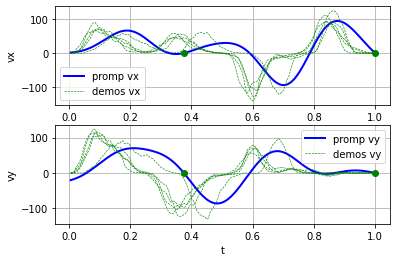

In [32]:
ax1 = plt.subplot(2, 1, 1)
ax1.plot(t0, pred_pv[2], 'b', label='promp vx', linewidth=2)
for i in range(demosNum):
    if i == 0:
        ax1.plot(t0, dataset[i][2], 'g--', linewidth=0.6, label='demos vx')
    else:
        ax1.plot(t0, dataset[i][2], 'g--', linewidth=0.6)
plt.plot(via_time1, via_point1[2], 'go')
plt.plot(via_time2, via_point2[2], 'go')
ax1.set_ylabel("vx")
plt.legend()
ax1.grid()
ax2 = plt.subplot(2, 1, 2)
ax2.plot(t0, pred_pv[3], 'b', label='promp vy', linewidth=2)
for i in range(demosNum):
    if i == 0:
        ax2.plot(t0, dataset[i][3], 'g--', linewidth=0.6, label='demos vy')
    else:
        ax2.plot(t0, dataset[i][3], 'g--', linewidth=0.6)
plt.plot(via_time1, via_point1[3], 'go')
plt.plot(via_time2, via_point2[3], 'go')
ax2.set_ylabel("vy")
ax2.set_xlabel("t")
plt.legend()
ax2.grid()
plt.show()

In [4]:
# ===== ProMP missing (prefix) completion under LOO (paste & run) =====
import numpy as np
from utils import (load_letter_all, split_indices, denormalize,
                   rmse, endpoint_err, jerk_score, timer, append_csv)

def rbf_design_matrix(T, num_basis=20, width=50.0):
    t = np.linspace(0,1,T)
    c = np.linspace(0,1,num_basis)
    Phi = np.exp(-width*(t[:,None]-c[None,:])**2)   # (T,B)
    Phi = Phi / (Phi.sum(axis=1, keepdims=True)+1e-8)
    return Phi

def promp_fit_W(preps_train, num_basis=20, width=50.0, lam=1e-6):
    T = preps_train[0]['pos'].shape[1]
    Phi = rbf_design_matrix(T, num_basis, width)      # (T,B)
    Phi2 = np.kron(np.eye(2), Phi)                    # (2T, 2B)
    W = []
    for p in preps_train:
        y = p['pos'].reshape(-1,1)                    # (2T,1)
        w = np.linalg.solve(Phi2.T@Phi2 + lam*np.eye(Phi2.shape[1]), Phi2.T@y).reshape(-1)
        W.append(w)
    W = np.stack(W, axis=0)                           # (H, 2B)
    mu_w = W.mean(axis=0)
    Sigma_w = np.cov(W.T) + lam*np.eye(W.shape[1])
    return mu_w, Sigma_w, Phi2

def promp_predict(mu_w, Phi2):          # (2B,) + (2T,2B) -> (2,T)
    y = Phi2 @ mu_w
    return y.reshape(2, -1)

def promp_condition(Phi_y, y_obs, Sigma_y, mu_w, Sigma_w):
    # y = Phi_y w + eps, eps ~ N(0, Sigma_y)
    S = Phi_y @ Sigma_w @ Phi_y.T + Sigma_y
    K = Sigma_w @ Phi_y.T @ np.linalg.inv(S)
    mu_post = mu_w + K @ (y_obs - Phi_y @ mu_w)
    Sigma_post = Sigma_w - K @ Phi_y @ Sigma_w
    return mu_post, Sigma_post

letters    = ['A','B','G','H']
T          = 200
num_basis  = 25
width      = 60.0
p_list     = [0.6, 0.4]                 # 给前 60% / 40% 的观测
save_csv   = 'results/missing.csv'
csv_header = ['method','letter','fold','p','rmse','end_err','jerk','train_ms','infer_ms']

for letter in letters:
    preps = load_letter_all(letter, T=T, norm='zscore')
    N = len(preps)
    print(f'[ProMP-missing:{letter}] demos={N}')
    for fold in range(N):
        tr_idx, te_idx = split_indices(N, mode='loo', loo_test=fold)
        preps_tr = [preps[i] for i in tr_idx]
        prep_te  = preps[te_idx[0]]

        with timer() as t_train:
            mu_w, Sigma_w, Phi2 = promp_fit_W(preps_tr, num_basis=num_basis, width=width, lam=1e-6)
        train_ms = t_train()

        T_te = prep_te['pos'].shape[1]
        Phi_full = Phi2                                   # (2T,2B)
        for p in p_list:
            L = int(T_te * p)                             # 观测长度
            # 观测矩阵：选取前 L 帧的 (x,y) 行
            sel = np.concatenate([np.arange(L), T_te + np.arange(L)])    # 2 维拼接
            Phi_y = Phi_full[sel, :]                      # (2L, 2B)
            y_obs = prep_te['pos'][:,:L].reshape(-1)      # (2L,)
            Sigma_y = 1e-6 * np.eye(2*L)                  # 小噪声=强约束

            with timer() as t_infer:
                mu_post, _ = promp_condition(Phi_y, y_obs, Sigma_y, mu_w, Sigma_w)
                y_pred_n = promp_predict(mu_post, Phi_full)             # (2,T)
            infer_ms = t_infer()

            y_pred = denormalize(y_pred_n, prep_te['stats'])
            y_true = denormalize(prep_te['pos'], prep_te['stats'])
            m = rmse(y_true, y_pred)
            e = endpoint_err(y_true, y_pred)
            j = jerk_score(y_pred, prep_te['dt'])

            append_csv(save_csv, csv_header, ['ProMP', letter, fold, p, m, e, j, train_ms, infer_ms])
            print(f'  fold={fold:02d} p={p:.1f}  RMSE={m:.4f}  end={e:.4f}  jerk={j:.4f}')
print('ProMP missing completion done ->', save_csv)


[ProMP-missing:A] demos=10
  fold=00 p=0.6  RMSE=1.5892  end=0.6807  jerk=57055.9916
  fold=00 p=0.4  RMSE=2.4527  end=2.4539  jerk=63271.3042
  fold=01 p=0.6  RMSE=0.3950  end=0.4207  jerk=28041.7678
  fold=01 p=0.4  RMSE=0.4603  end=0.3990  jerk=27850.0503
  fold=02 p=0.6  RMSE=0.3323  end=0.6593  jerk=30829.7974
  fold=02 p=0.4  RMSE=0.5195  end=0.8277  jerk=32958.4850
  fold=03 p=0.6  RMSE=0.2448  end=0.4558  jerk=29118.8087
  fold=03 p=0.4  RMSE=0.3194  end=0.2534  jerk=25823.0314
  fold=04 p=0.6  RMSE=0.2283  end=0.1396  jerk=27935.9886
  fold=04 p=0.4  RMSE=0.2780  end=0.2892  jerk=26801.7691
  fold=05 p=0.6  RMSE=0.2824  end=0.8366  jerk=28874.2498
  fold=05 p=0.4  RMSE=0.6888  end=0.6220  jerk=29891.7874
  fold=06 p=0.6  RMSE=0.4036  end=0.6941  jerk=23522.4892
  fold=06 p=0.4  RMSE=0.4643  end=0.4325  jerk=27533.9576
  fold=07 p=0.6  RMSE=0.7538  end=0.3094  jerk=34356.0094
  fold=07 p=0.4  RMSE=1.1146  end=0.7151  jerk=33740.2844
  fold=08 p=0.6  RMSE=0.3030  end=0.7762  jer